In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(color_codes=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


## Load the data

In [3]:
df = pd.read_csv('../cleaned_data/EXCL.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,3.059533,3.007273,2.938809,1.053684,1.761675,1.705354,1.715120,0.324503,0.722584,0.996105,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,3.395286
2012-10-18,3.111350,3.046031,2.964583,1.915311,1.761675,1.705354,1.715120,0.787275,0.583963,0.928232,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,3.395286
2012-10-19,3.176120,3.081559,2.988210,1.970523,1.998807,1.924055,1.909460,1.382241,0.657416,0.968922,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,3.486288
2012-10-22,3.253845,3.120318,3.016132,1.767559,0.597816,1.020966,1.207254,-0.102020,-0.091455,0.026726,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,3.304284
2012-10-23,3.299184,3.149386,3.035463,0.647818,0.093460,0.636550,0.891438,-0.494746,-0.343995,0.057185,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,3.213282


### Plot the Close price - our target

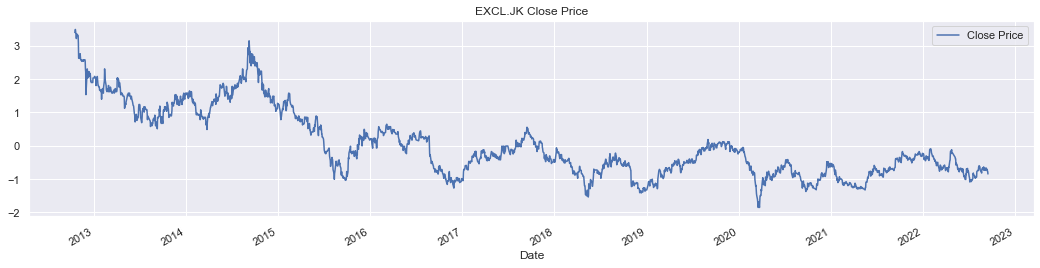

In [4]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('EXCL.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [5]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Modeling

### Regression with Deep Neural Network

In [7]:
from utils import build_and_compile_model, fit_model

In [8]:
from utils import genPredictions, inversePredsAndAct, evaluateModel

In [9]:
from joblib import load

close_scaler = load('../feature_engineering/excl_close_scaler.bin')

In [11]:
epochs_cands = [100,150,200]
batch_size_cands = [32,64,128]
performances = {}
models = {}
predictions_dfs = {}
inversed_dfs = {}

modelID = 1
for epochs in epochs_cands:
    for batch_size in batch_size_cands:
        print(f'\n==========MODEL {modelID} with epochs: {epochs} and batch size: {batch_size}==========')
        model = build_and_compile_model(17)
        history = fit_model(model, epochs, batch_size, train_features, train_labels)
        models[f'Model-{modelID}'] = (model, history)
        predictions = genPredictions(model, df, test_features, train_len)
        predictions_dfs[f'Model-{modelID}'] = predictions
        
        inversed = inversePredsAndAct(predictions, close_scaler, test_labels)
        inversed_dfs[f'Model-{modelID}'] = inversed
        rmse_, mape_, rsquared_ = evaluateModel(inversed)
        performances[f'Model-{modelID}'] = {
            'Epochs': epochs,
            'Batch Size': batch_size,
            'RMSE': rmse_,
            'MAPE': mape_,
            'R2': rsquared_
        }
        
        modelID += 1
        


==========MODEL 1 with epochs: 100 and batch size: 32==========
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1152      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 1ms/step

==========MODEL 2 with epochs: 100 and batch size: 64==========
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shap

Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 2ms/step


In [12]:
performance_df = pd.DataFrame(performances).transpose()
performance_df[['Epochs', 'Batch Size']] = performance_df[['Epochs', 'Batch Size']].astype(int)
performance_df.head(9)

,Epochs,Batch Size,RMSE,MAPE,R2
Model-1,100,32,96.801480,2.818942,0.922279
Model-2,100,64,97.103259,2.699808,0.921793
Model-3,100,128,134.432518,3.706954,0.850106
Model-4,150,32,90.740112,2.798892,0.931707
Model-5,150,64,120.424872,3.769888,0.879716
Model-6,150,128,121.213629,3.763941,0.878135
Model-7,200,32,99.934801,2.937935,0.917166
Model-8,200,64,109.587195,3.273577,0.900392
Model-9,200,128,72.427678,2.211798,0.956490


### Plot the best model

In [16]:
from utils import plotPredAct, plotErrorHist

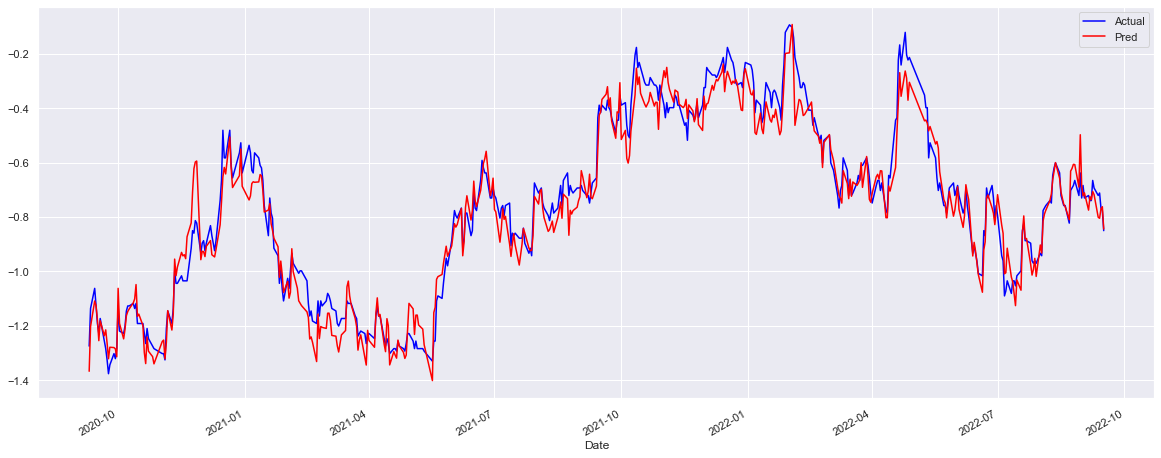

In [17]:
plotPredAct(predictions_dfs['Model-9'])

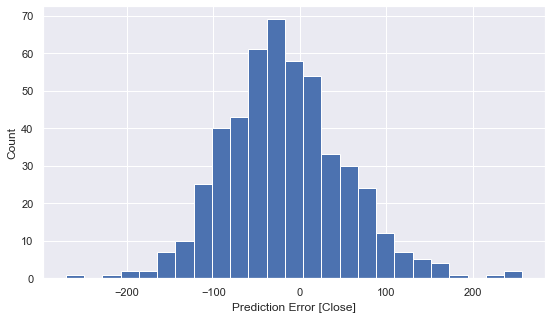

In [23]:
plt.figure(figsize=(9,5))
plotErrorHist(inversed_dfs['Model-9'])

### Save the best model

In [24]:
models['Model-9'][0].save('./models/excl.h5')

In [25]:
loadedModel = keras.models.load_model('./models/excl.h5')

In [26]:
loadedModel.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                1152      
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
